In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import cv2
import sys
import numpy as np
from skimage import segmentation
import torch.nn.init
from matplotlib import pyplot as plt

In [37]:
image = cv2.imread(input, cv2.IMREAD_COLOR)
segments = segmentation.slic(image, compactness=10000, sigma=0.1, )

TypeError: Invalid shape (1024,) for image data

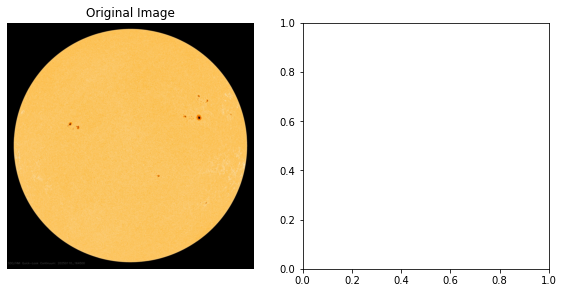

In [ ]:
from skimage.segmentation import chan_vese

# Apply Chan-Vese segmentation

# Convert image to grayscale if it's not already
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Chan-Vese segmentation
cv_mask = chan_vese(gray_image, mu=0.05, lambda1=1, lambda2=1, tol=1e-3, max_num_iter=300,
                    dt=0.5)


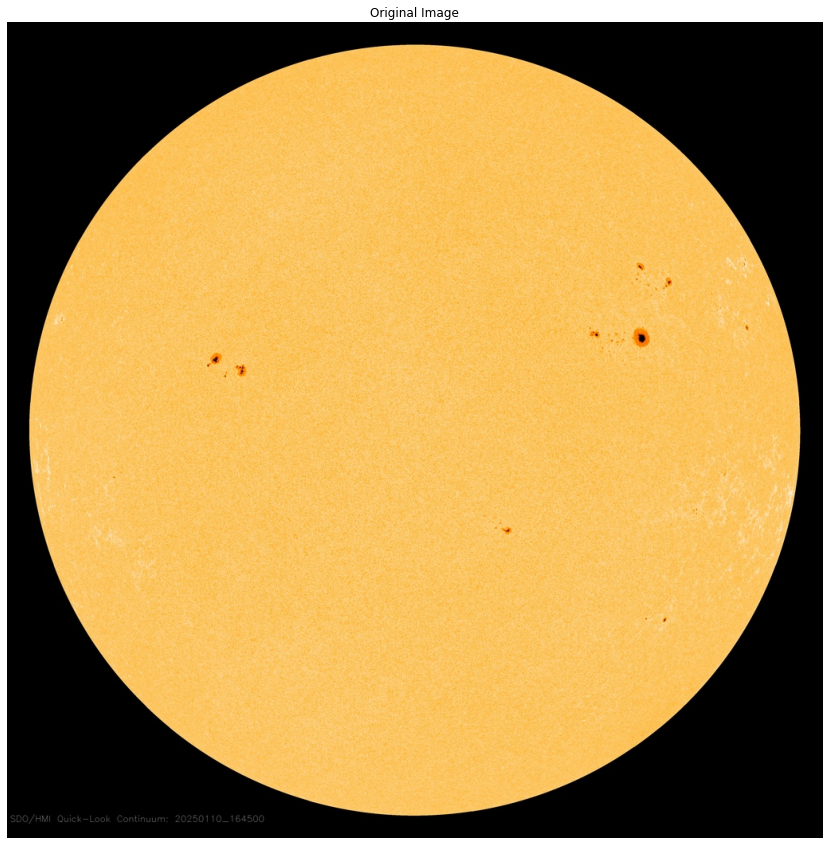

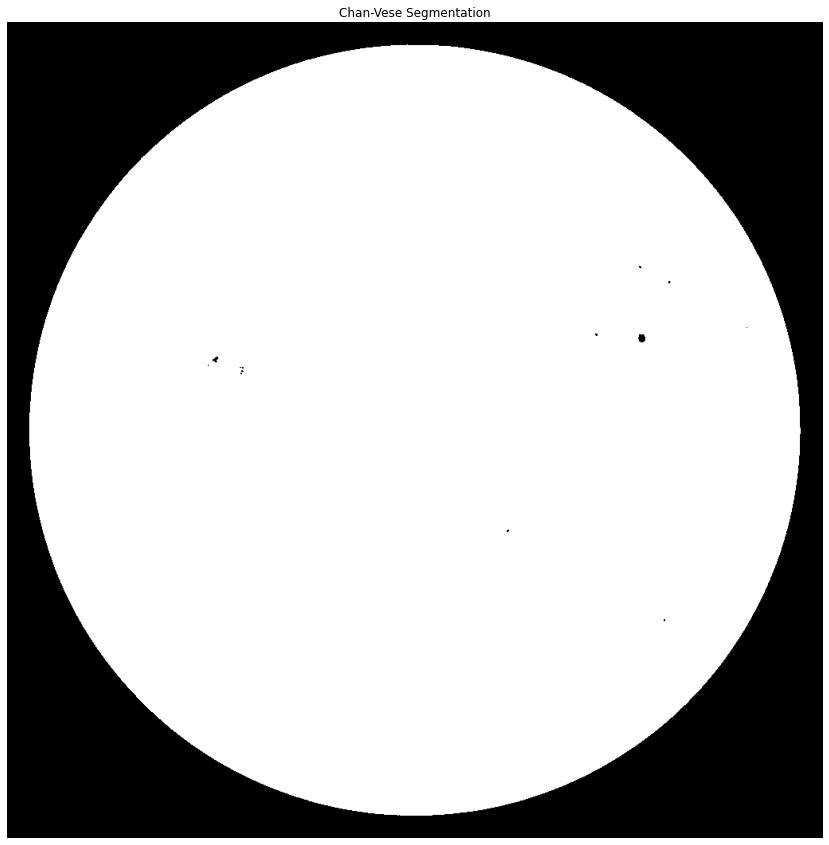

In [53]:
# Display results
plt.figure(figsize=(15, 15))

# plt.subplot(131)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.show()

# plt.subplot(132)
plt.figure(figsize=(15, 15))
plt.imshow(cv_mask, cmap='gray')
plt.title('Chan-Vese Segmentation')
plt.axis('off')


plt.show()

In [3]:
nChannel = 128
maxIter = 1600
minLabels = 3
lr = 0.1
nConv = 2
num_superpixels = 1000
compactness = 100
visualize = 1
input = '../images/20250110_164500_1024_HMIIF.jpg'

In [55]:
#from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import cv2
import sys
import numpy as np
from skimage import segmentation
import torch.nn.init

use_cuda = torch.cuda.is_available()

# CNN model
class MyNet(nn.Module):
    def __init__(self,input_dim):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(input_dim, nChannel, kernel_size=3, stride=1, padding=1 )
        self.bn1 = nn.BatchNorm2d(nChannel)
        self.conv2 = nn.ModuleList()
        self.bn2 = nn.ModuleList()
        for i in range(nConv-1):
            self.conv2.append( nn.Conv2d(nChannel, nChannel, kernel_size=3, stride=1, padding=1 ) )
            self.bn2.append( nn.BatchNorm2d(nChannel) )
        self.conv3 = nn.Conv2d(nChannel, nChannel, kernel_size=1, stride=1, padding=0 )
        self.bn3 = nn.BatchNorm2d(nChannel)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu( x )
        x = self.bn1(x)
        for i in range(nConv-1):
            x = self.conv2[i](x)
            x = F.relu( x )
            x = self.bn2[i](x)
        x = self.conv3(x)
        x = self.bn3(x)
        return x

# load image
im = cv2.imread(input)
data = torch.from_numpy( np.array([im.transpose( (2, 0, 1) ).astype('float32')/255.]) )
if use_cuda:
    data = data.cuda()
data = Variable(data)

# slic
labels = segmentation.slic(im, compactness=compactness, n_segments=num_superpixels)
labels = labels.reshape(im.shape[0]*im.shape[1])
u_labels = np.unique(labels)
l_inds = []
for i in range(len(u_labels)):
    l_inds.append( np.where( labels == u_labels[ i ] )[ 0 ] )

# train
model = MyNet( data.size(1) )
if use_cuda:
    model.cuda()
model.train()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
label_colours = np.random.randint(255,size=(100,3))
for batch_idx in range(maxIter):
    # forwarding
    optimizer.zero_grad()
    output = model( data )[ 0 ]
    output = output.permute( 1, 2, 0 ).contiguous().view( -1, nChannel )
    ignore, target = torch.max( output, 1 )
    im_target = target.data.cpu().numpy()
    nLabels = len(np.unique(im_target))
    # if visualize:
    #     im_target_rgb = np.array([label_colours[ c % 100 ] for c in im_target])
    #     im_target_rgb = im_target_rgb.reshape( im.shape ).astype( np.uint8 )
    #     cv2.imshow( "output", im_target_rgb )
    #     cv2.waitKey(10)

    # superpixel refinement
    for i in range(len(l_inds)):
        labels_per_sp = im_target[ l_inds[ i ] ]
        u_labels_per_sp = np.unique( labels_per_sp )
        hist = np.zeros( len(u_labels_per_sp) )
        for j in range(len(hist)):
            hist[ j ] = len( np.where( labels_per_sp == u_labels_per_sp[ j ] )[ 0 ] )
        im_target[ l_inds[ i ] ] = u_labels_per_sp[ np.argmax( hist ) ]
    target = torch.from_numpy( im_target )
    if use_cuda:
        target = target.cuda()
    target = Variable( target )
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()

    #print (batch_idx, '/', maxIter, ':', nLabels, loss.data[0])
    print (batch_idx, '/', maxIter, ':', nLabels, loss.item())

    if nLabels <= minLabels:
        print ("nLabels", nLabels, "reached minLabels", minLabels, ".")
        break

# save output image
if not visualize:
    output = model( data )[ 0 ]
    output = output.permute( 1, 2, 0 ).contiguous().view( -1, nChannel )
    ignore, target = torch.max( output, 1 )
    im_target = target.data.cpu().numpy()
    im_target_rgb = np.array([label_colours[ c % 100 ] for c in im_target])
    im_target_rgb = im_target_rgb.reshape( im.shape ).astype( np.uint8 )

cv2.imwrite( "output_CNN.png", im_target_rgb )

0 / 1600 : 127 4.459201335906982
1 / 1600 : 124 4.433599472045898
2 / 1600 : 105 4.303988456726074
3 / 1600 : 97 4.179471969604492
4 / 1600 : 74 3.9953627586364746
5 / 1600 : 54 3.7596254348754883
6 / 1600 : 41 3.462533950805664
7 / 1600 : 39 3.0962541103363037
8 / 1600 : 30 2.6891114711761475
9 / 1600 : 24 2.26076078414917
10 / 1600 : 22 1.830920696258545
11 / 1600 : 17 1.4171909093856812
12 / 1600 : 14 1.0376243591308594
13 / 1600 : 14 0.7241912484169006
14 / 1600 : 12 0.48240187764167786
15 / 1600 : 8 0.3109951317310333
16 / 1600 : 8 0.19883455336093903
17 / 1600 : 6 0.1286361664533615
18 / 1600 : 4 0.08532759547233582
19 / 1600 : 3 0.058461036533117294
nLabels 3 reached minLabels 3 .


True

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
from PIL import Image
import glob

# Custom dataset to load images from a folder
import random

class SunspotDataset(Dataset):
    def __init__(self, image_folder, transform=None, sample_fraction=0.15):
        # Get all image paths
        all_image_paths = glob.glob(os.path.join(image_folder, '*'))
        
        # Randomly sample fraction of images
        num_samples = int(len(all_image_paths) * sample_fraction)
        self.image_paths = random.sample(all_image_paths, num_samples)
        self.transform = transform
        print(f"Using {len(self.image_paths)} images out of {len(all_image_paths)} total images")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, 0



# Data augmentation and preprocessing transforms
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [13]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
from PIL import Image
import glob
from tqdm import tqdm

# Create dataset with only 15% of images or it's too long on my computer :(
dataset = SunspotDataset(image_folder='../images', 
                        transform=data_transforms,
                        sample_fraction=0.15)

train_size = int(0.95 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Reduced batch size and number of workers
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

# Simplified autoencoder with fewer layers
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop with progress bar
num_epochs = 7
try:
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # Add progress bar for training
        train_pbar = tqdm(train_loader, desc=f'Epoch [{epoch+1}/{num_epochs}]')
        for images, _ in train_pbar:
            try:
                images = images.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, images)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * images.size(0)
                
                # Update progress bar
                train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
                
            except RuntimeError as e:
                print(f"Error in batch: {e}")
                continue
                
        epoch_loss = running_loss / train_size
        print(f"\nTraining Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, _ in tqdm(val_loader, desc='Validation'):
                try:
                    images = images.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, images)
                    val_loss += loss.item() * images.size(0)
                except RuntimeError as e:
                    print(f"Error in validation batch: {e}")
                    continue
                    
        val_loss /= val_size
        print(f"Validation Loss: {val_loss:.4f}")

except KeyboardInterrupt:
    print("\nTraining interrupted by user")

Using 243 images out of 1624 total images


Epoch [1/7]: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s, loss=0.4863]



Training Loss: 0.5319


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Validation Loss: 0.4768


Epoch [2/7]: 100%|██████████| 15/15 [00:04<00:00,  3.26it/s, loss=0.3024]



Training Loss: 0.3962


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


Validation Loss: 0.2907


Epoch [3/7]: 100%|██████████| 15/15 [00:04<00:00,  3.24it/s, loss=0.1690]



Training Loss: 0.2258


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Validation Loss: 0.1630


Epoch [4/7]: 100%|██████████| 15/15 [00:04<00:00,  3.25it/s, loss=0.0854]



Training Loss: 0.1226


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Validation Loss: 0.0812


Epoch [5/7]: 100%|██████████| 15/15 [00:04<00:00,  3.27it/s, loss=0.0398]



Training Loss: 0.0593


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


Validation Loss: 0.0380


Epoch [6/7]: 100%|██████████| 15/15 [00:04<00:00,  3.25it/s, loss=0.0212]



Training Loss: 0.0286


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Validation Loss: 0.0209


Epoch [7/7]: 100%|██████████| 15/15 [00:04<00:00,  3.17it/s, loss=0.0154]



Training Loss: 0.0178


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

Validation Loss: 0.0150


In [14]:
model_save_path = 'autoencoder_model1.pth'
torch.save(model.state_dict(), model_save_path)

In [54]:
def evaluate_image(model, image_path, device):
    # Load and preprocess the image
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    # Load and transform image
    image = Image.open(image_path).convert("RGB")
    original_image = image.copy()
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)
    
    # Evaluate
    model.eval()
    with torch.no_grad():
        output = model(image)
    
    # Convert output tensor to image
    output = output.cpu().squeeze(0)  # Remove batch dimension
    output = output * 0.5 + 0.5  # Denormalize
    output = output.clamp(0, 1)  # Ensure values are in [0,1]
    output = transforms.ToPILImage()(output)
    
    return original_image, output

C:\Users\guezz\AppData\Local\Temp/ipykernel_11980/1111274292.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


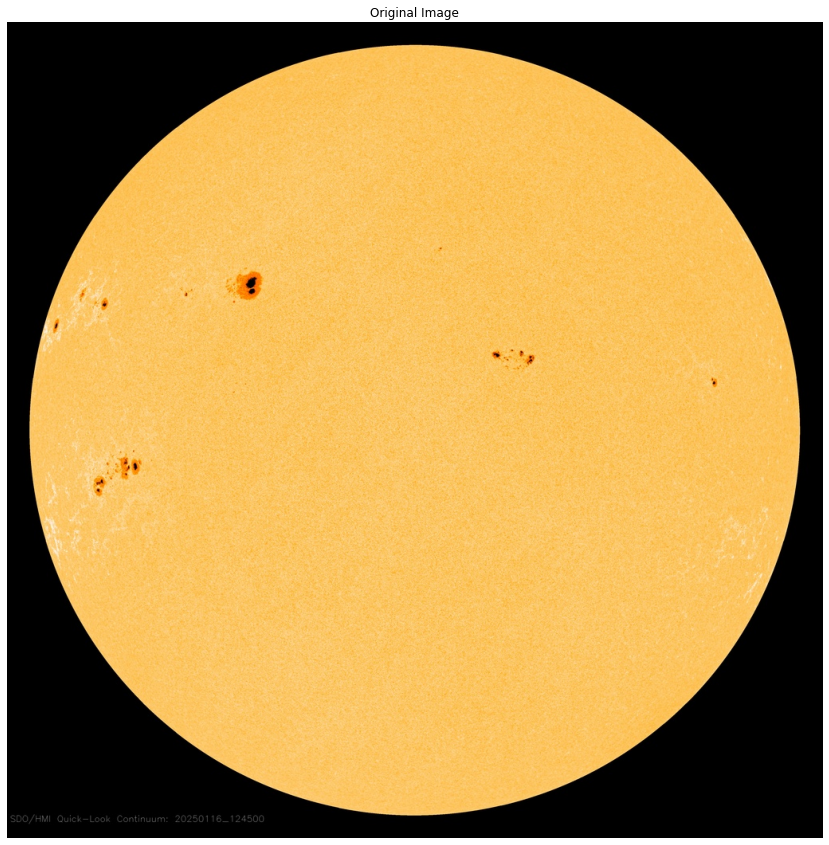

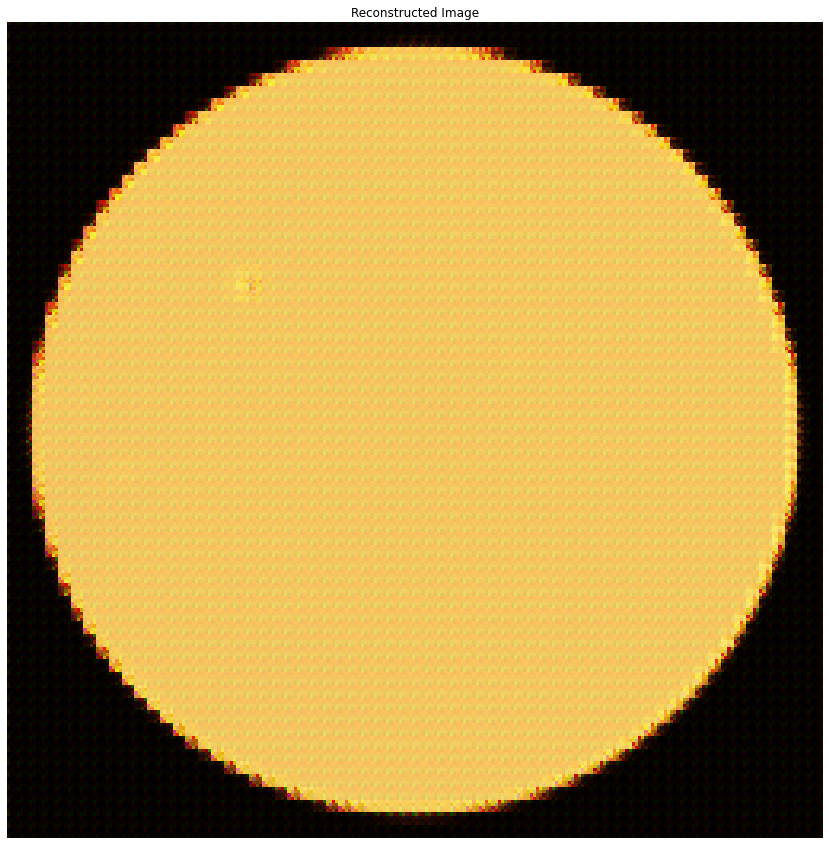

In [16]:
# Load the model (if you're using it in a different session)
model = ConvAutoencoder().to(device)
model.load_state_dict(torch.load(model_save_path))

# Evaluate a single image
image_path = '../images/20250116_124500_1024_HMIIF.jpg'
original, reconstructed = evaluate_image(model, image_path, device)

# Display results
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
# plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title('Original Image')
plt.axis('off')
plt.show()

# plt.subplot(1, 2, 2)
plt.figure(figsize=(15, 15))
plt.imshow(reconstructed)
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()

New try

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from torchvision import transforms

class SunspotSegmenter(nn.Module):
    def __init__(self):
        super(SunspotSegmenter, self).__init__()
        # Encoder - extracts features
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Decoder - generates segmentation mask
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, kernel_size=1),
            nn.Sigmoid()  # Output between 0 and 1 for binary segmentation
        )

    def forward(self, x):
        # Encoding
        x1 = self.enc1(x)
        x = self.pool1(x1)
        
        x2 = self.enc2(x)
        x = self.pool2(x2)
        
        # Decoding with skip connections
        x = self.upsample1(x)
        x = self.dec1(x)
        
        x = self.upsample2(x)
        x = self.dec2(x)
        
        return x

In [24]:
class SunspotDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_paths = glob.glob(os.path.join(image_folder, '*'))
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Create ground truth mask using traditional method
        gray = np.array(image.convert('L'))
        mask = (gray < 128).astype(np.float32)  # Simple threshold for training
        
        if self.transform:
            image = self.transform(image)
            mask = torch.from_numpy(mask).unsqueeze(0)  # Add channel dimension
            
        return image, mask

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SunspotSegmenter().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}')

# Inference function
def detect_sunspots(model, image_path, device, threshold=0.5):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    image = Image.open(image_path).convert('RGB')
    original = image.copy()
    image = transform(image).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        mask = model(image)
        mask = (mask > threshold).float()
        mask = mask.cpu().squeeze().numpy()
    
    # Calculate properties
    from skimage import measure
    labels = measure.label(mask)
    props = measure.regionprops(labels)
    
    return {
        'original': original,
        'mask': mask,
        'num_spots': len(props),
        'areas': [prop.area for prop in props],
        'centroids': [prop.centroid for prop in props]
    }

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training: 100%|██████████| 1/1 [01:32<00:00, 92.05s/it, avg_loss=0.0008]


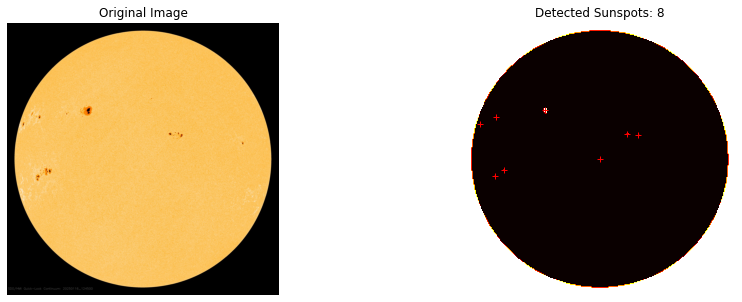

In [28]:
class SunspotDataset(Dataset):
    def __init__(self, image_folder, transform=None, img_size=(256, 256)):
        self.image_paths = glob.glob(os.path.join(image_folder, '*'))
        self.transform = transform
        self.img_size = img_size
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        # Create mask from grayscale image
        gray = np.array(image.convert('L'))
        mask = (gray < 128).astype(np.float32)
        
        # Convert mask to PIL Image for resizing
        mask = Image.fromarray(mask)
        
        # Resize both image and mask to the same size
        image = image.resize(self.img_size, Image.BILINEAR)
        mask = mask.resize(self.img_size, Image.NEAREST)
        
        if self.transform:
            image = self.transform(image)
            # Convert mask to tensor and add channel dimension
            mask = torch.from_numpy(np.array(mask)).float().unsqueeze(0)
        
        return image, mask

# Modified training setup
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create dataset with explicit image size
dataset = SunspotDataset(
    image_folder='../images', 
    transform=transform, 
    img_size=(256, 256)
)

# Create data loader
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Training with progress bars remains the same
train_model(model, train_loader)


# Training
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = SunspotDataset('../images', transform=transform)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

from tqdm.auto import tqdm

def train_model(model, train_loader, num_epochs=1):
    # Progress bar for epochs
    epoch_pbar = tqdm(range(num_epochs), desc='Training', position=0)
    
    for epoch in epoch_pbar:
        model.train()
        running_loss = 0.0
        
        # Progress bar for batches
        batch_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', 
                         leave=False, position=1)
        
        for images, masks in batch_pbar:
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Update batch progress bar
            batch_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        # Update epoch progress bar
        avg_loss = running_loss/len(train_loader)
        epoch_pbar.set_postfix({'avg_loss': f'{avg_loss:.4f}'})

dataset = SunspotDataset('../images', transform=transform,)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)
train_model(model, train_loader)

# Inference
results = detect_sunspots(model, '../images/20250116_124500_1024_HMIIF.jpg', device)

# Visualization
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(results['original'])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(results['mask'], cmap='hot')
plt.title(f'Detected Sunspots: {results["num_spots"]}')
for i, centroid in enumerate(results['centroids']):
    plt.plot(centroid[1], centroid[0], 'r+')
plt.axis('off')
plt.show()

In [29]:
torch.save(model.state_dict(), 'new_model.pth')

In [31]:
model2 = SunspotSegmenter().to(device)
model2.load_state_dict(torch.load('new_model.pth'))

C:\Users\guezz\AppData\Local\Temp/ipykernel_11980/715430431.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load('new_model.pth'))


<All keys matched successfully>

In [32]:
results2 = detect_sunspots(model2, '../images/20250116_003000_1024_HMIIF.jpg', device)

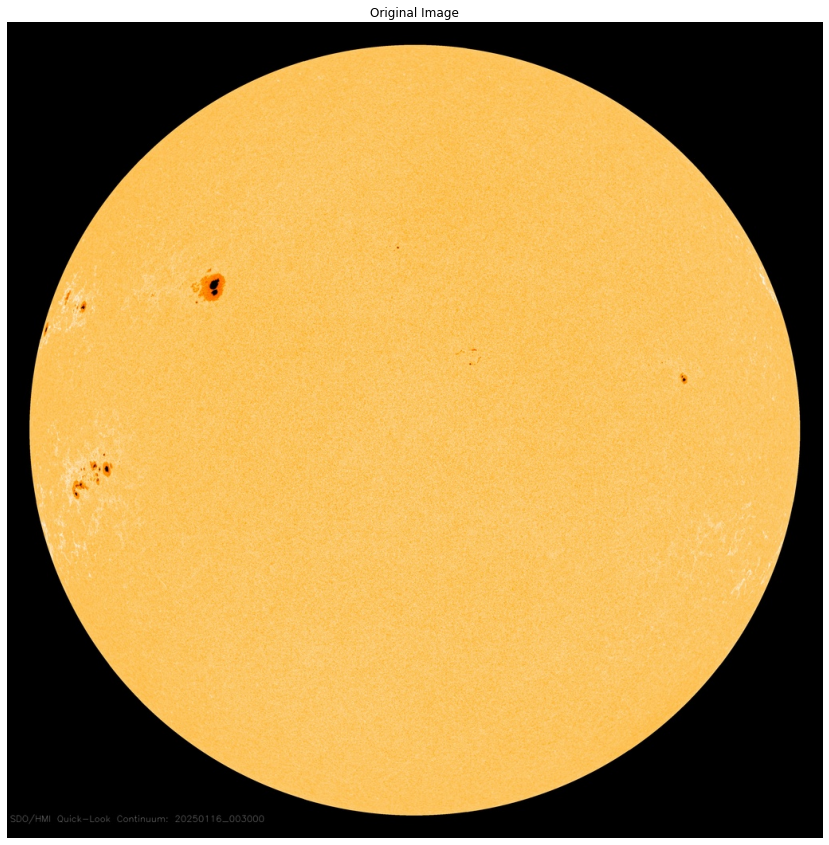

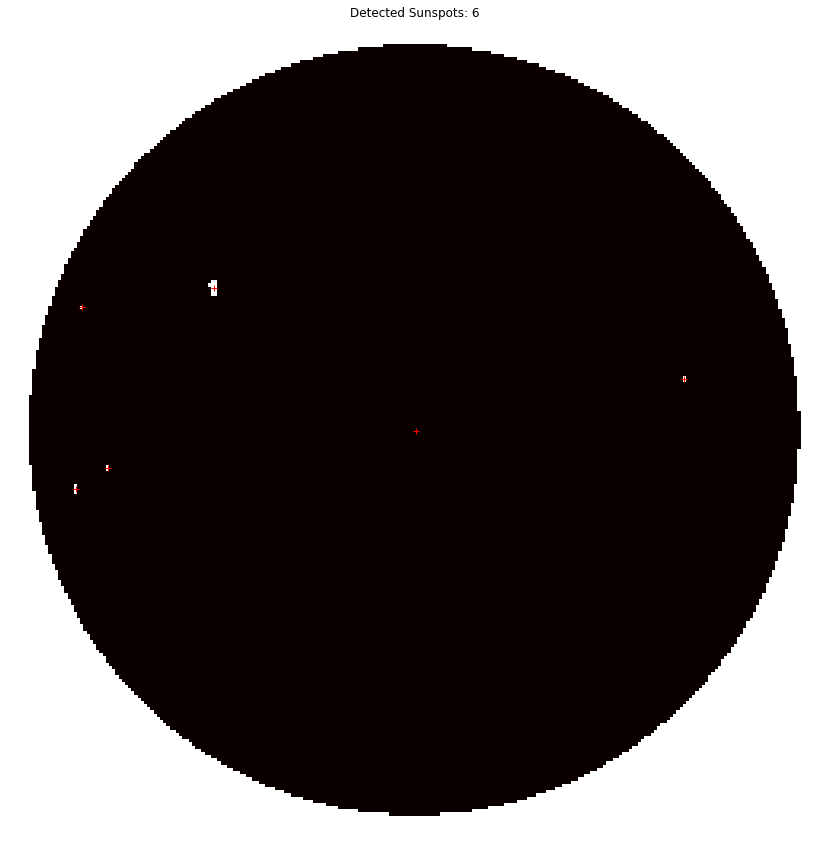

In [52]:
plt.figure(figsize=(15, 15))
plt.imshow(results2['original'])
plt.title('Original Image')
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 15))
plt.imshow(results2['mask'], cmap='hot')
plt.title(f'Detected Sunspots: {results2["num_spots"]}')
for i, centroid in enumerate(results2['centroids']):
    plt.plot(centroid[1], centroid[0], 'r+')

plt.axis('off')
plt.show()

In [45]:
results2['mask'].shape

(256, 256)

renormalization, as the mask is only of size 256x256 instead of 1024x1024

In [49]:
[a*1024/results2['mask'].shape[0] for a in results2['areas']]

[78672.0, 44.0, 4.0, 8.0, 8.0, 12.0]

In [57]:
image = Image.open('../images/20250110_164500_1024_HMIIF.jpg')
original_image = image.copy()
type(original_image)

PIL.Image.Image

A FAIRE :  TOUT NETTOYER, FAIRE LE PY propre, ECRIRE LE README, CORRIGER LA METH1 DANS LE CAS OU LA TACHE EST AU BORD ?

In [ ]:
def detect_sunspots(model, image_path, device, threshold=0.5):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    image = Image.open(image_path).convert('RGB')
    original = image.copy()
    image = transform(image).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        mask = model(image)
        mask = (mask > threshold).float()
        mask = mask.cpu().squeeze().numpy()
    
    # Calculate properties
    from skimage import measure
    labels = measure.label(mask)
    props = measure.regionprops(labels)
    
    return {
        'original': original,
        'mask': mask,
        'num_spots': len(props),
        'areas': [prop.area for prop in props],
        'centroids': [prop.centroid for prop in props]
    }


def analyze_sunspots(results, min_area=7, output_folder='output'):    
    # Get mask and original image
    mask = results['mask']
    original_image = np.array(results['original'])
    
    # Resize mask to match original image size (1024x1024)
    mask_resized = cv2.resize(
        mask.astype(np.float32), 
        (original_image.shape[1], original_image.shape[0]),
        interpolation=cv2.INTER_NEAREST
    )
    
    # Get connected components
    labels = measure.label(mask_resized, connectivity=2, background=0)
    regionprops = measure.regionprops(labels)
    
    # Filter regions (using original scale min_area)
    regionprops = [prop for prop in regionprops if 
                   10000 >= prop.area >= min_area]
    
    # Create border mask
    border_mask = np.zeros_like(original_image)
    
    # Draw borders
    for region in regionprops:
        filled_area = region.filled_image
        minr, minc, maxr, maxc = region.bbox
        
        # Create temporary mask
        temp_mask = np.zeros((maxr - minr, maxc - minc), dtype=bool)
        temp_mask[0:filled_area.shape[0], 0:filled_area.shape[1]] = filled_area
        
        # Find boundary pixels
        for x in range(temp_mask.shape[0]):
            for y in range(temp_mask.shape[1]):
                if temp_mask[x, y]:
                    # Check boundary condition
                    if (x == 0 or x == temp_mask.shape[0]-1 or 
                        y == 0 or y == temp_mask.shape[1]-1 or
                        not temp_mask[x-1, y] or not temp_mask[x+1, y] or
                        not temp_mask[x, y-1] or not temp_mask[x, y+1]):
                        border_mask[x + minr, y + minc] = [255, 255, 255]
    
    # Superpose borders
    border_superposed = cv2.addWeighted(original_image, 1, border_mask, 1, 0)
    
    # Print analysis
    print(f'Number of sunspots: {len(regionprops)}')
    print('')
    for i, prop in enumerate(regionprops):
        print(f'Sunspot {i + 1}: {int(prop.area)} pixels')
    
    # Save results
    output_path = f'{output_folder}/detected_sunspots_{timestamp}.jpg'
    cv2.imwrite(output_path, cv2.cvtColor(border_superposed, cv2.COLOR_RGB2BGR))
    print(f'Image with borders saved at {output_path}')